In [1]:
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import os
import sys

#
# from sklearn.preprocessing import KBinsDiscretizer
from joblib import Parallel, delayed
from tqdm import tqdm
# Ruta de entrada en el clúster
file_path = "datos/Land_and_Ocean_EqualArea.nc"

    # Abrir el dataset
data = xr.open_dataset(file_path)
latitudes = data['latitude'].values
longitudes = data['longitude'].values
temperature = data['temperature'].values

Década 1850: Modularidad = 0.4256, Número de Comunidades = 7


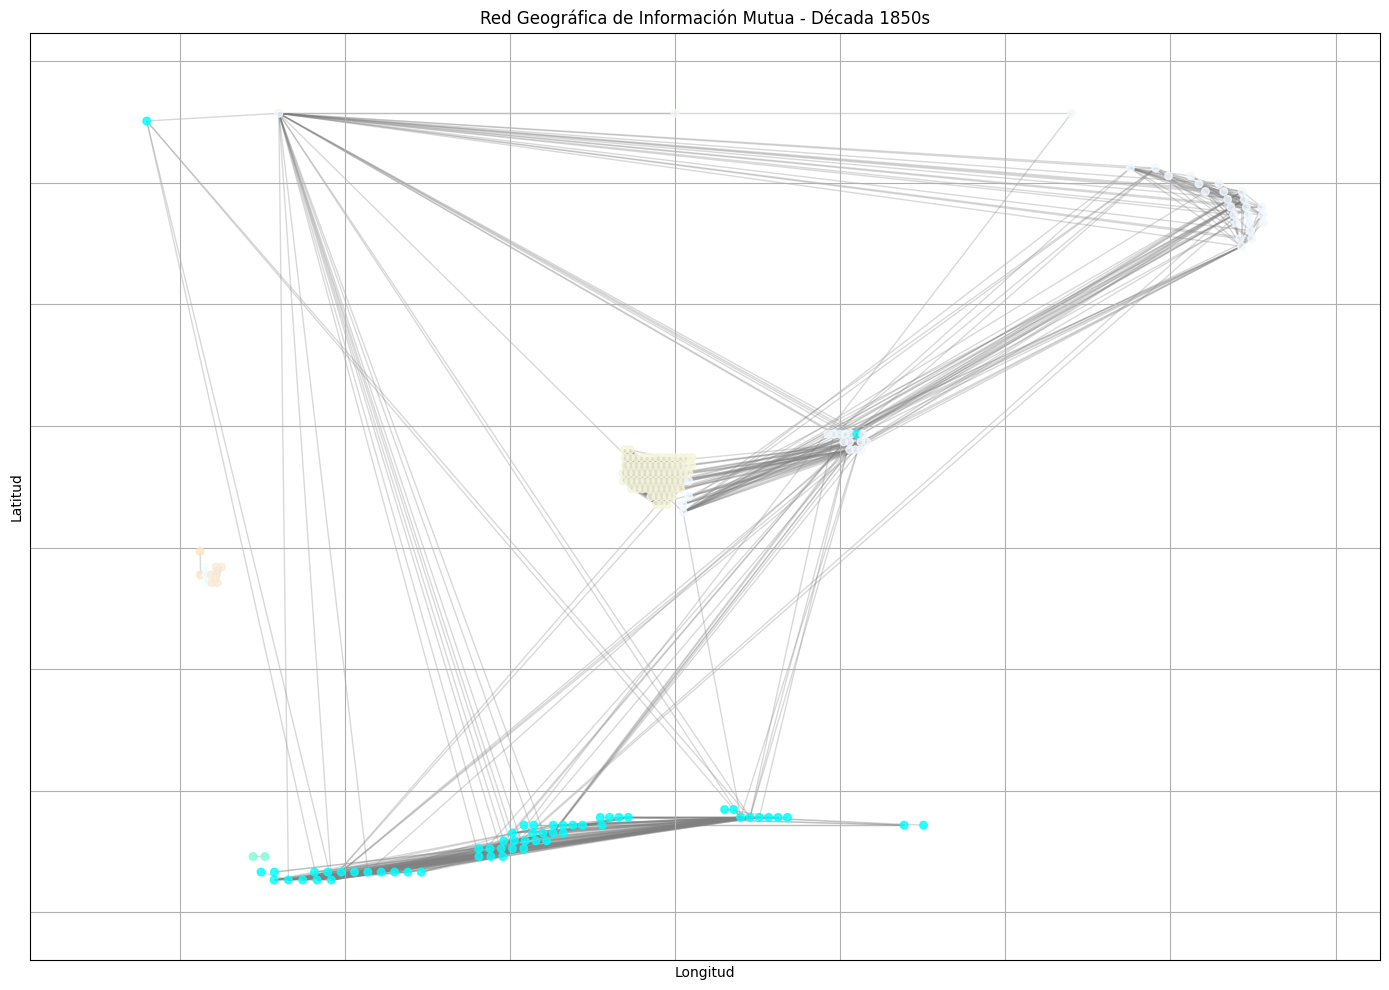

Década 1860: Modularidad = 0.0578, Número de Comunidades = 26


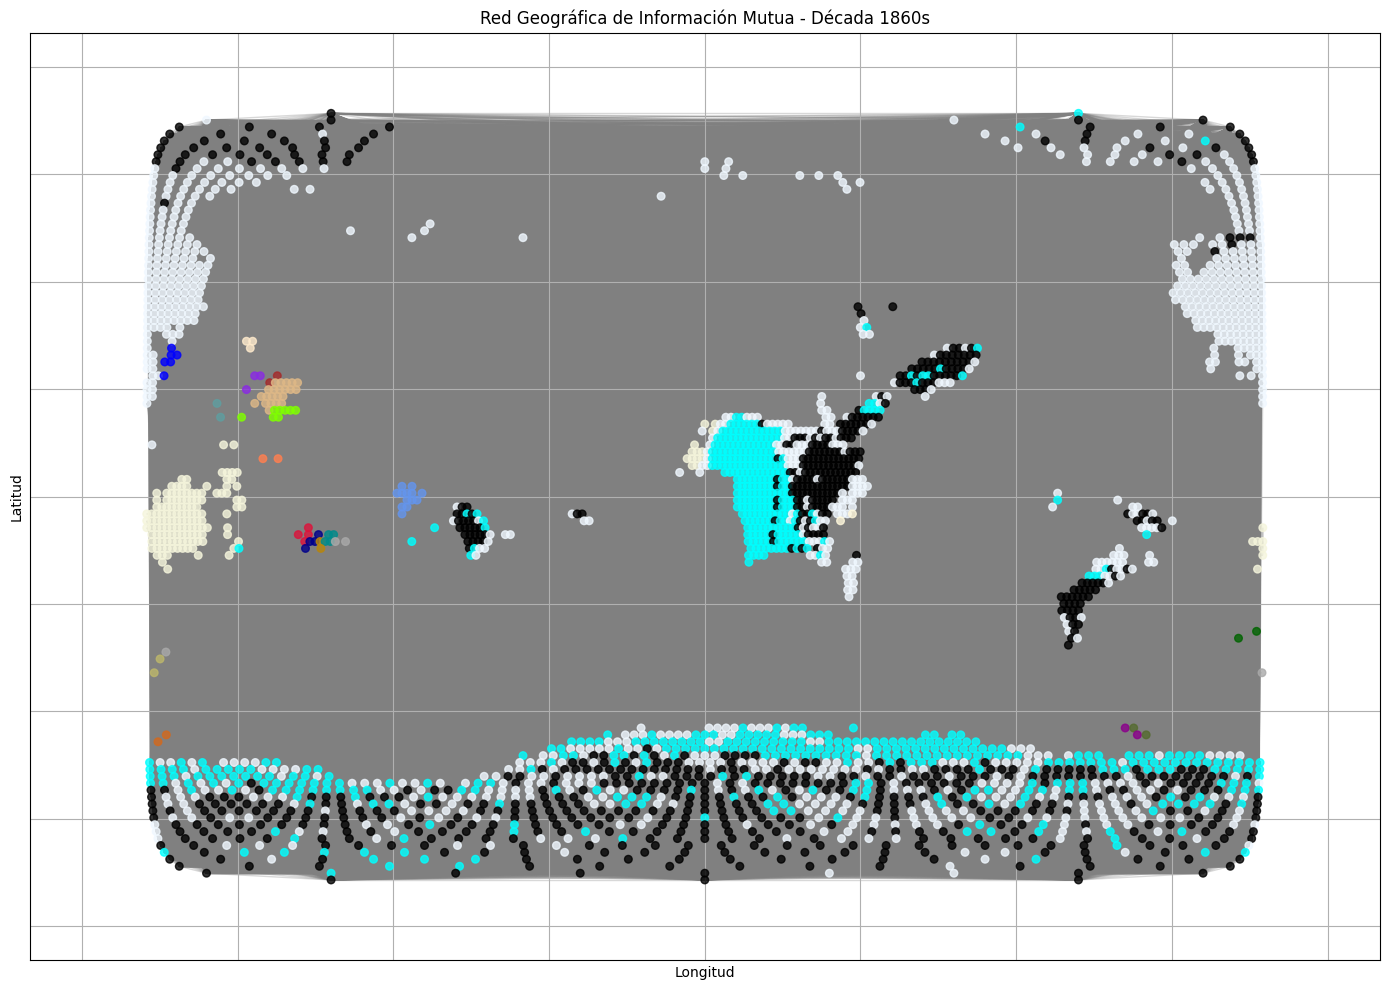

Década 1870: Modularidad = 0.0509, Número de Comunidades = 12


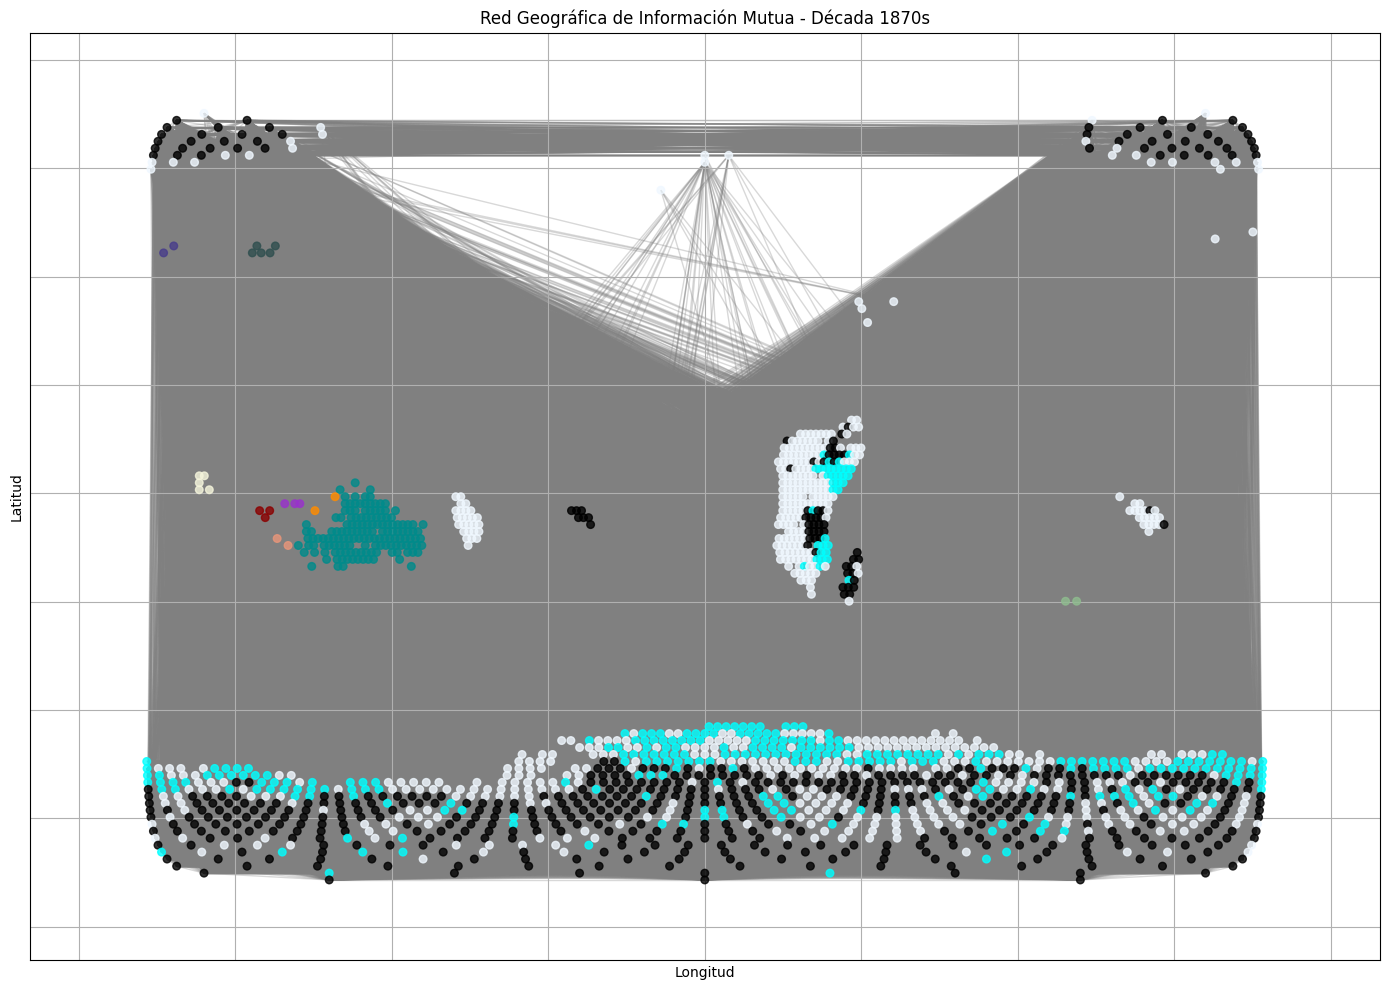

Década 1880: Modularidad = 0.0453, Número de Comunidades = 4


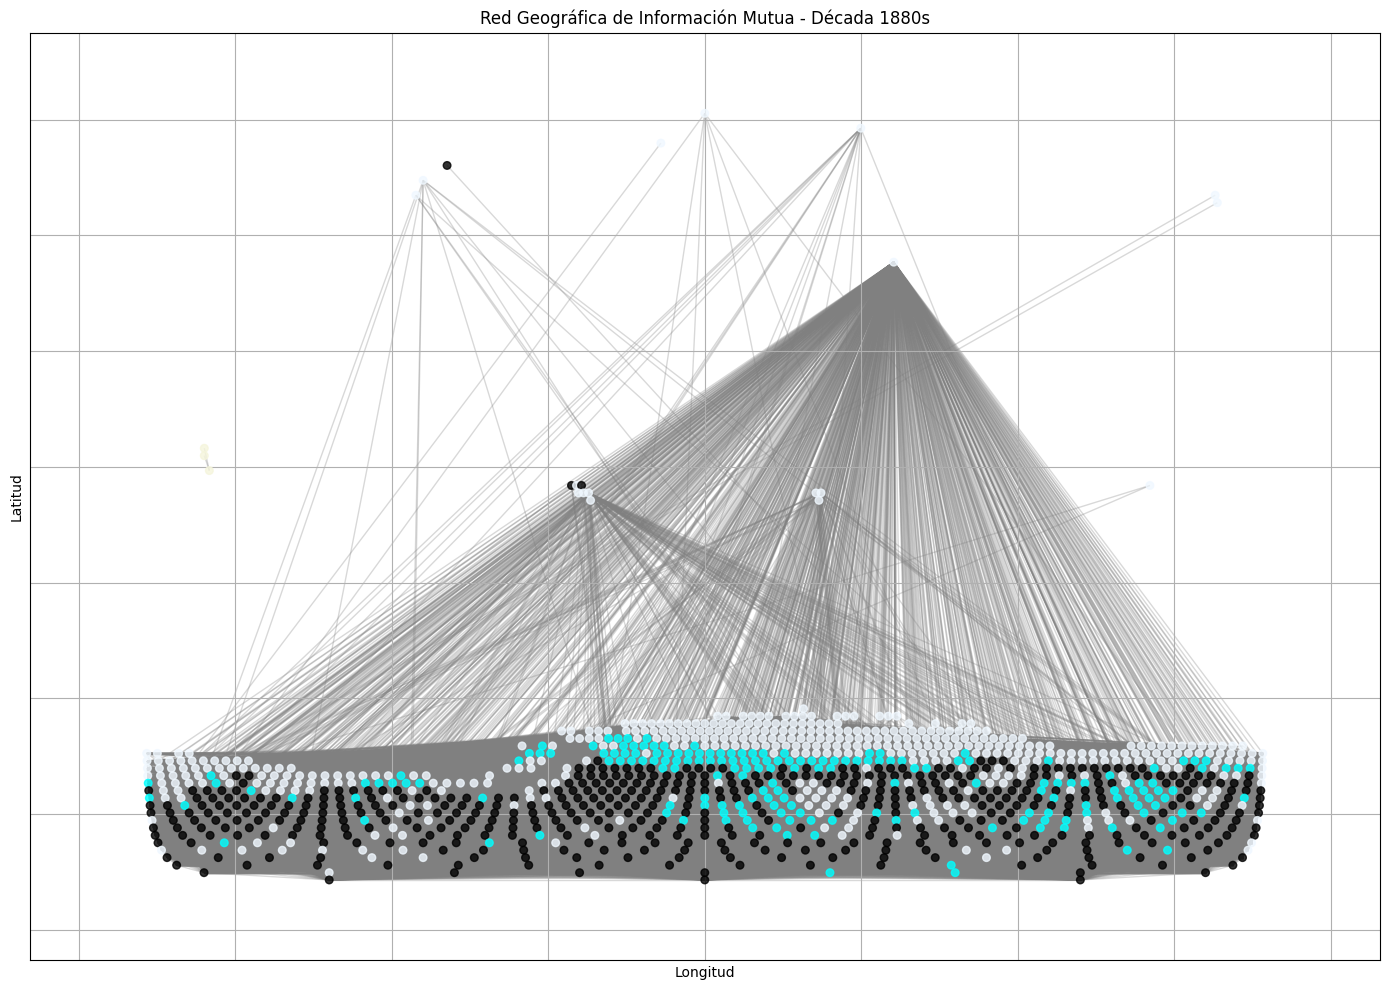

Década 1890: Modularidad = 0.0555, Número de Comunidades = 14


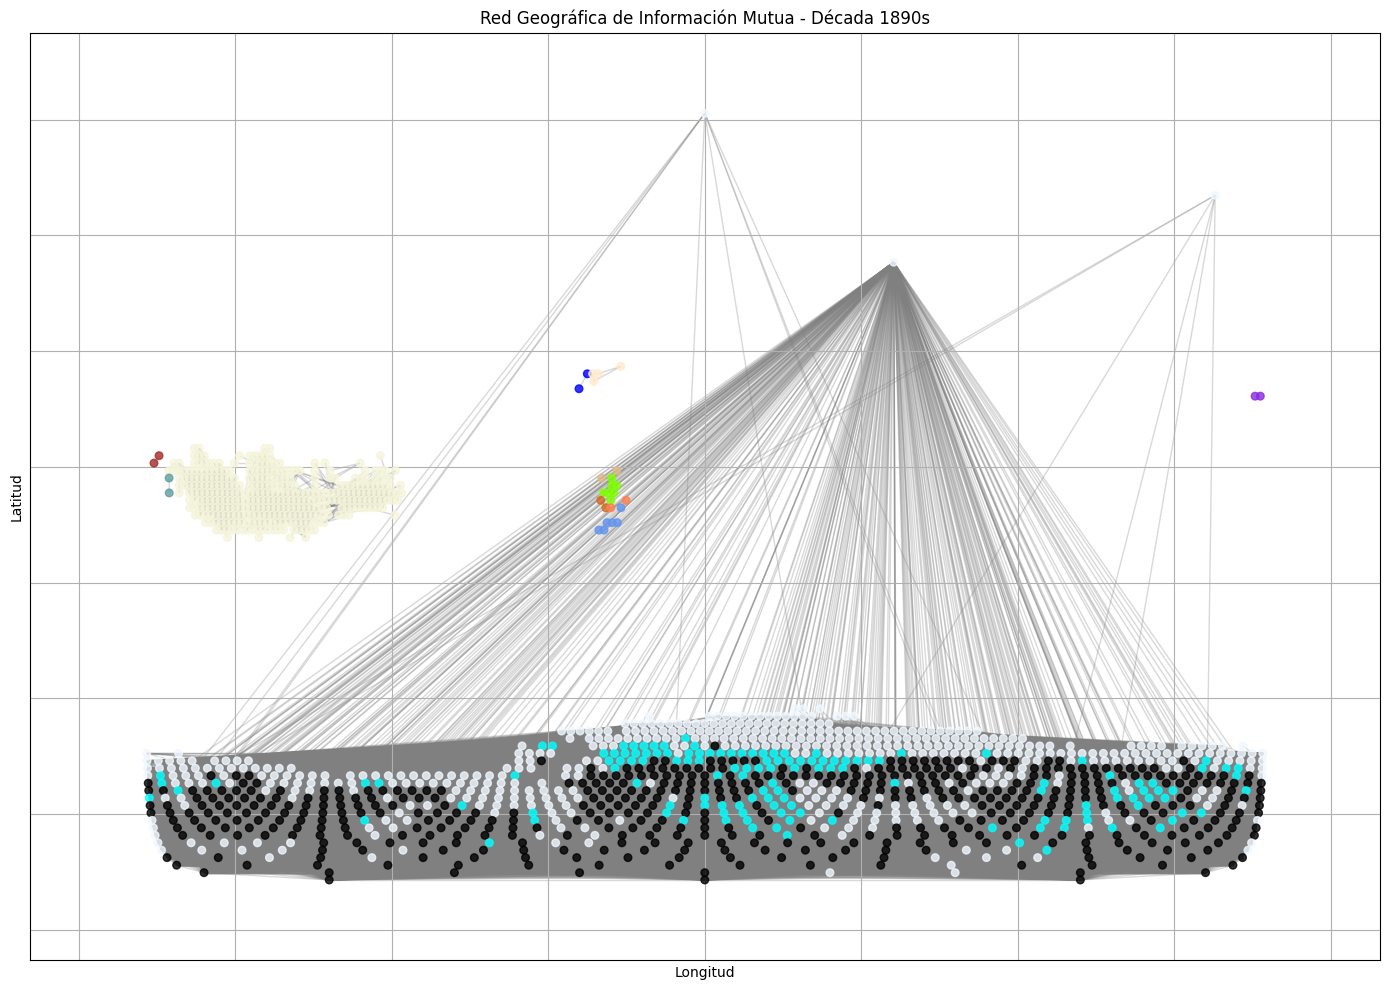

Década 1900: Modularidad = 0.0785, Número de Comunidades = 15


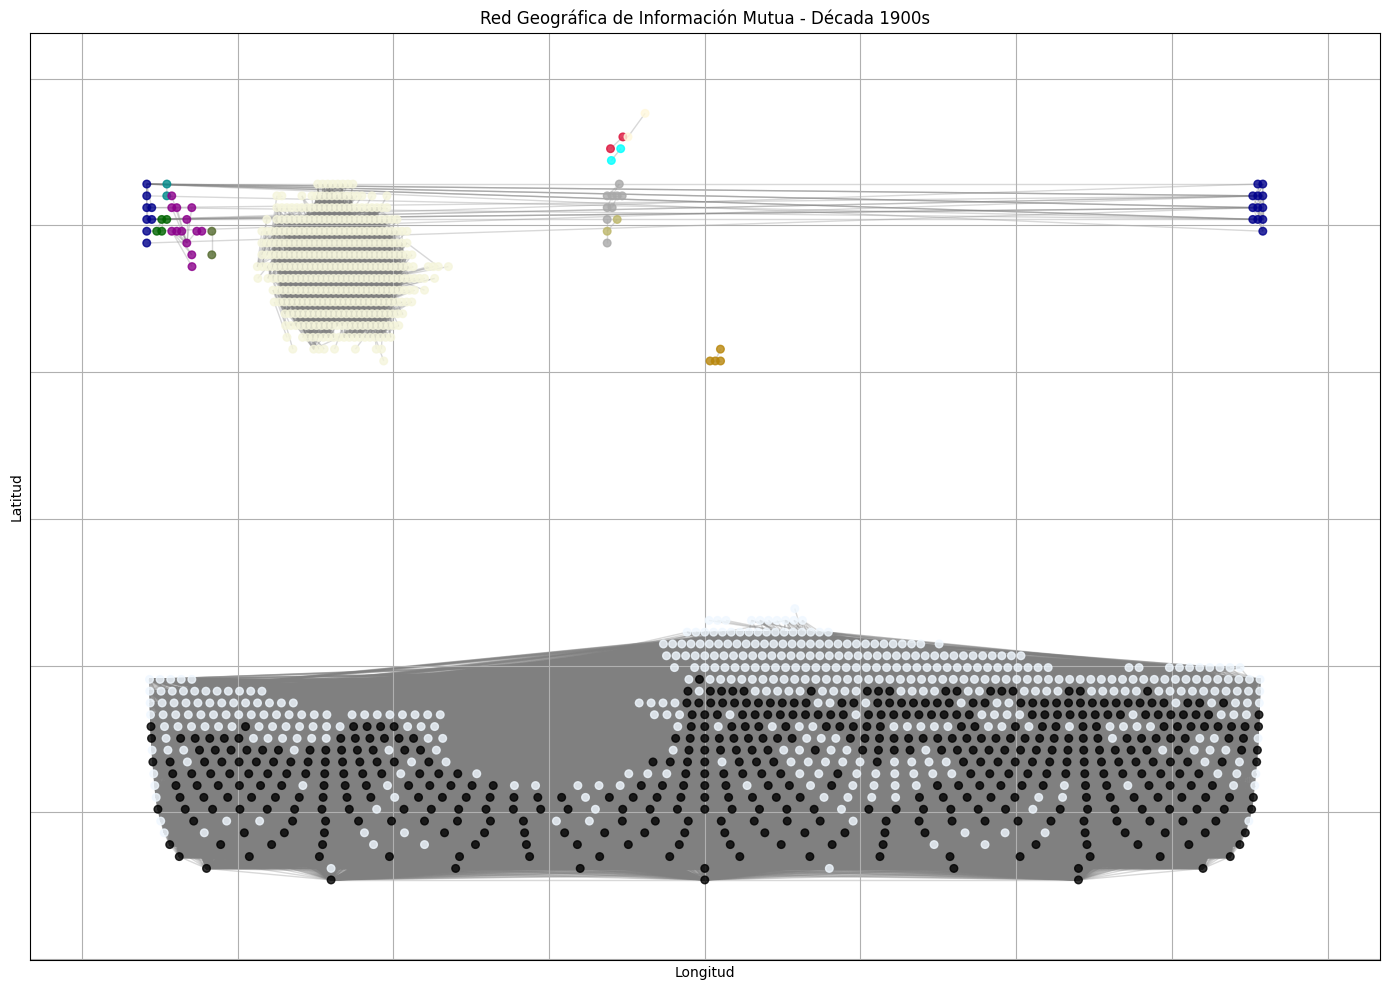

Década 1910: Modularidad = 0.0411, Número de Comunidades = 8


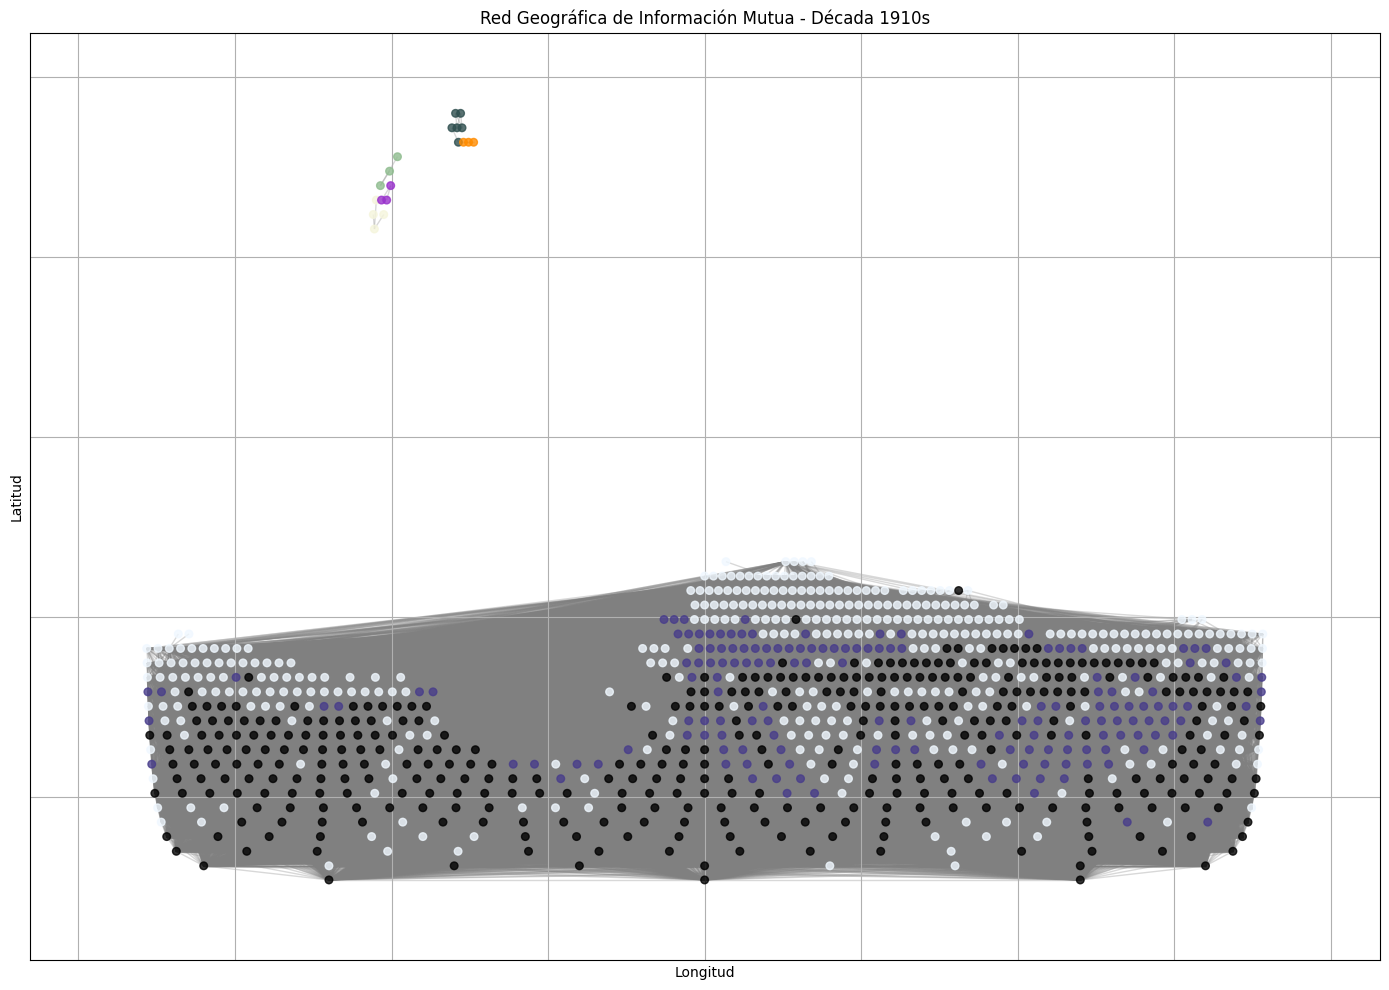

Década 1920: Modularidad = 0.0563, Número de Comunidades = 3


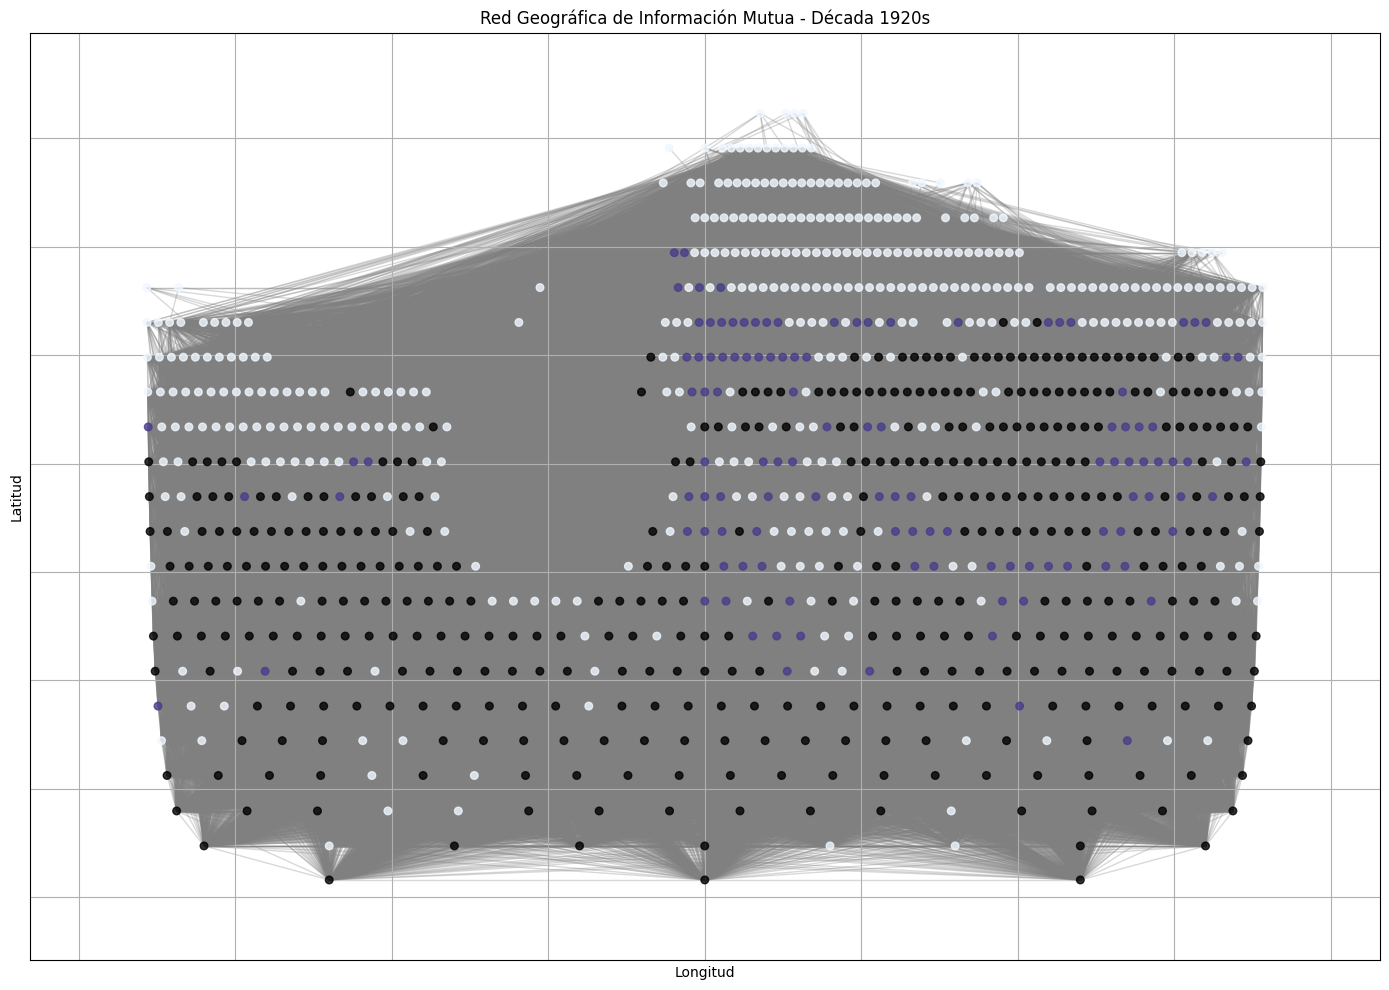

Década 1930: Modularidad = 0.0774, Número de Comunidades = 9


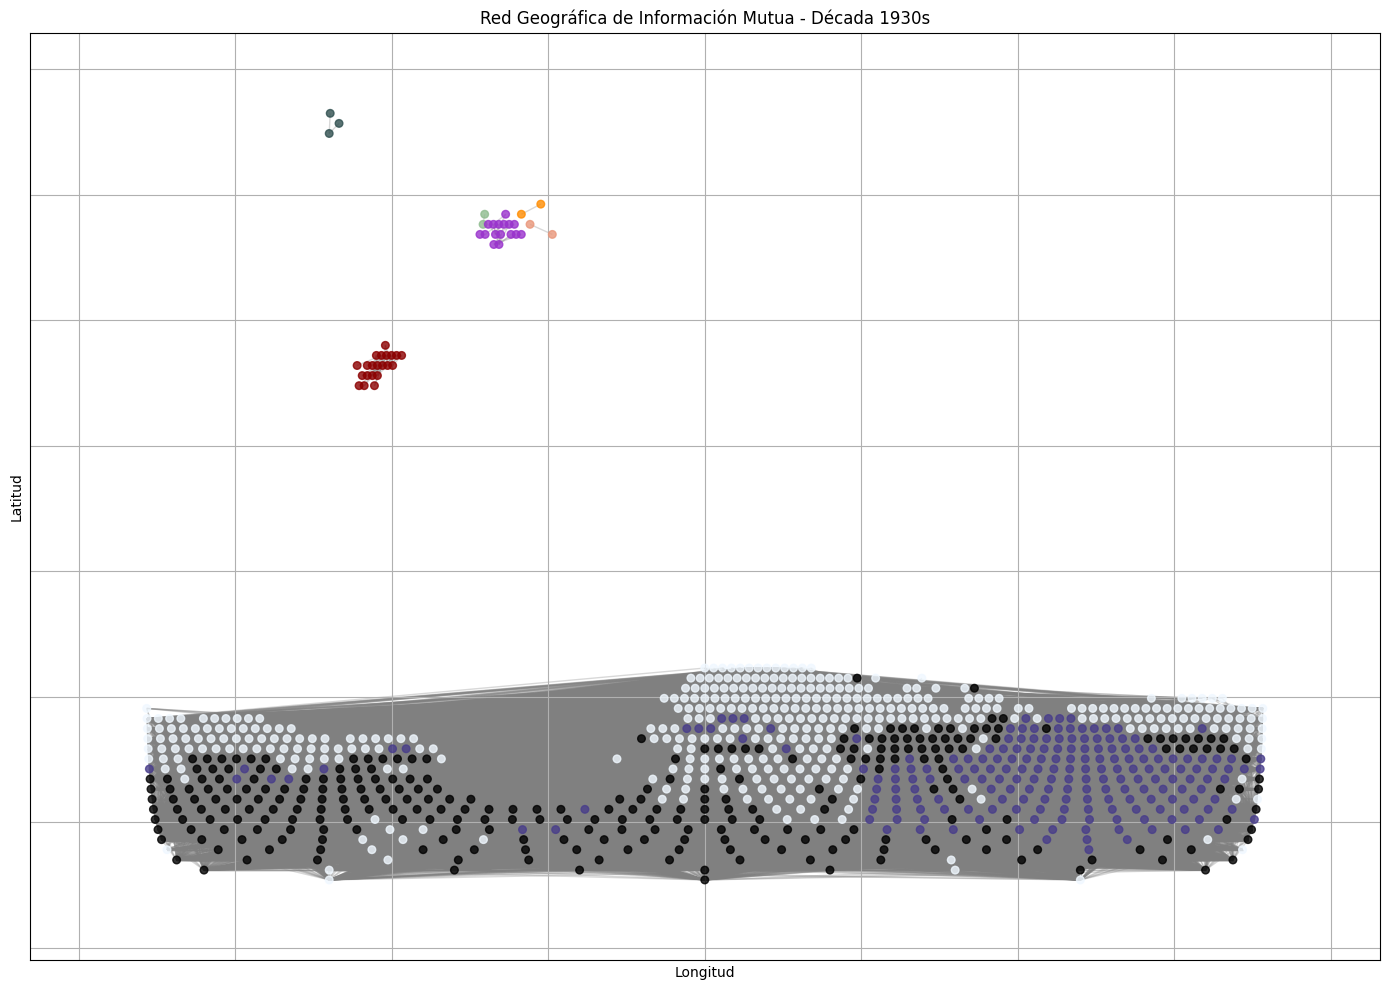

Década 1940: Modularidad = 0.1898, Número de Comunidades = 11


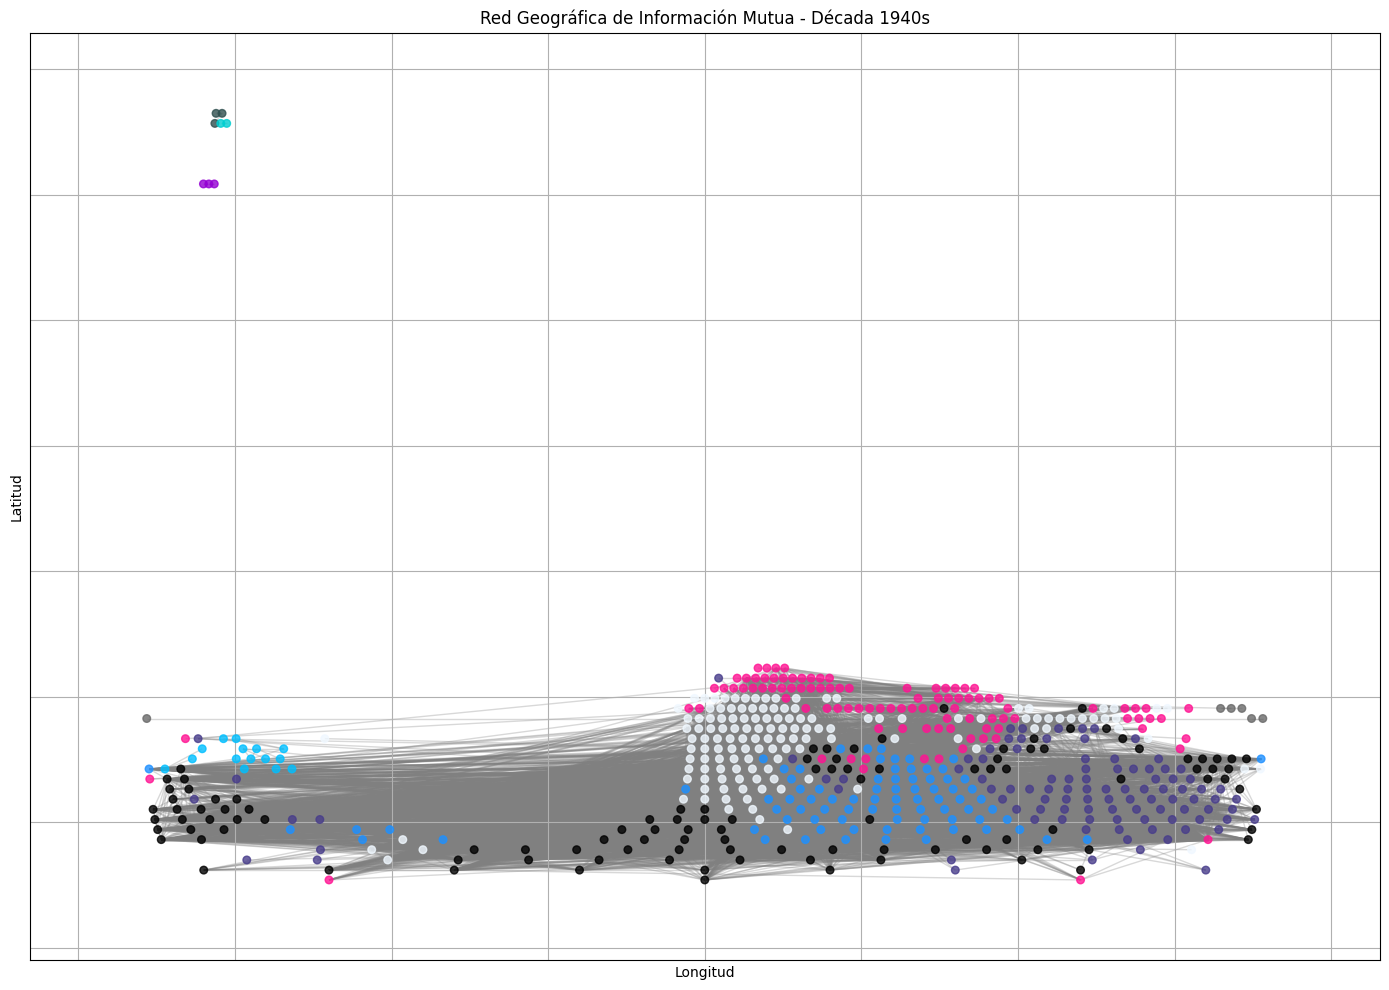

Década 1950: Modularidad = 0.5151, Número de Comunidades = 19


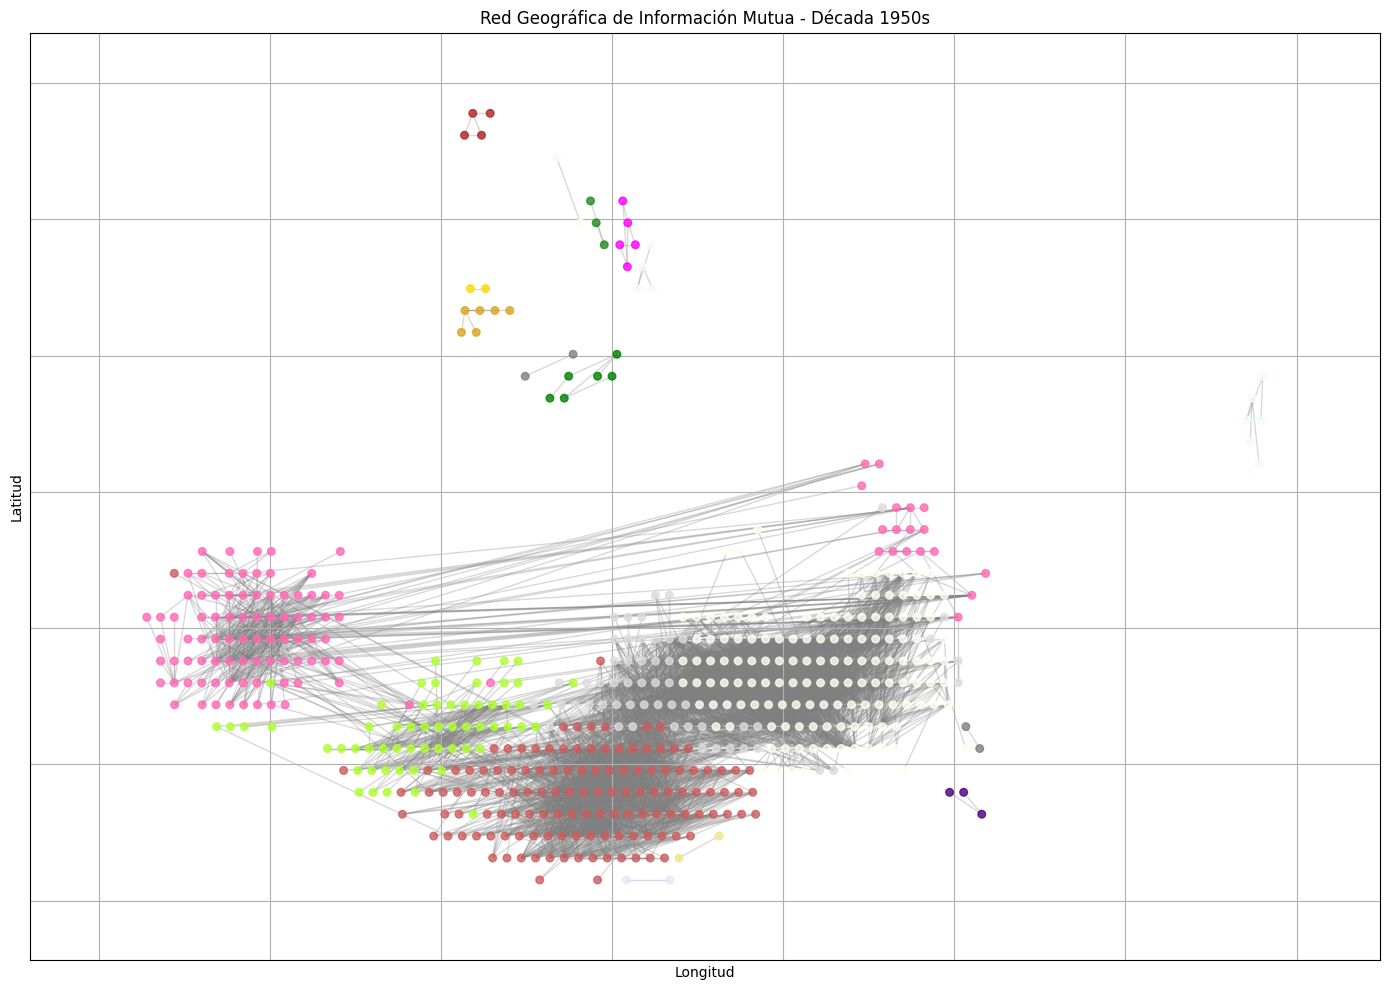

Década 1960: Modularidad = 0.3392, Número de Comunidades = 22


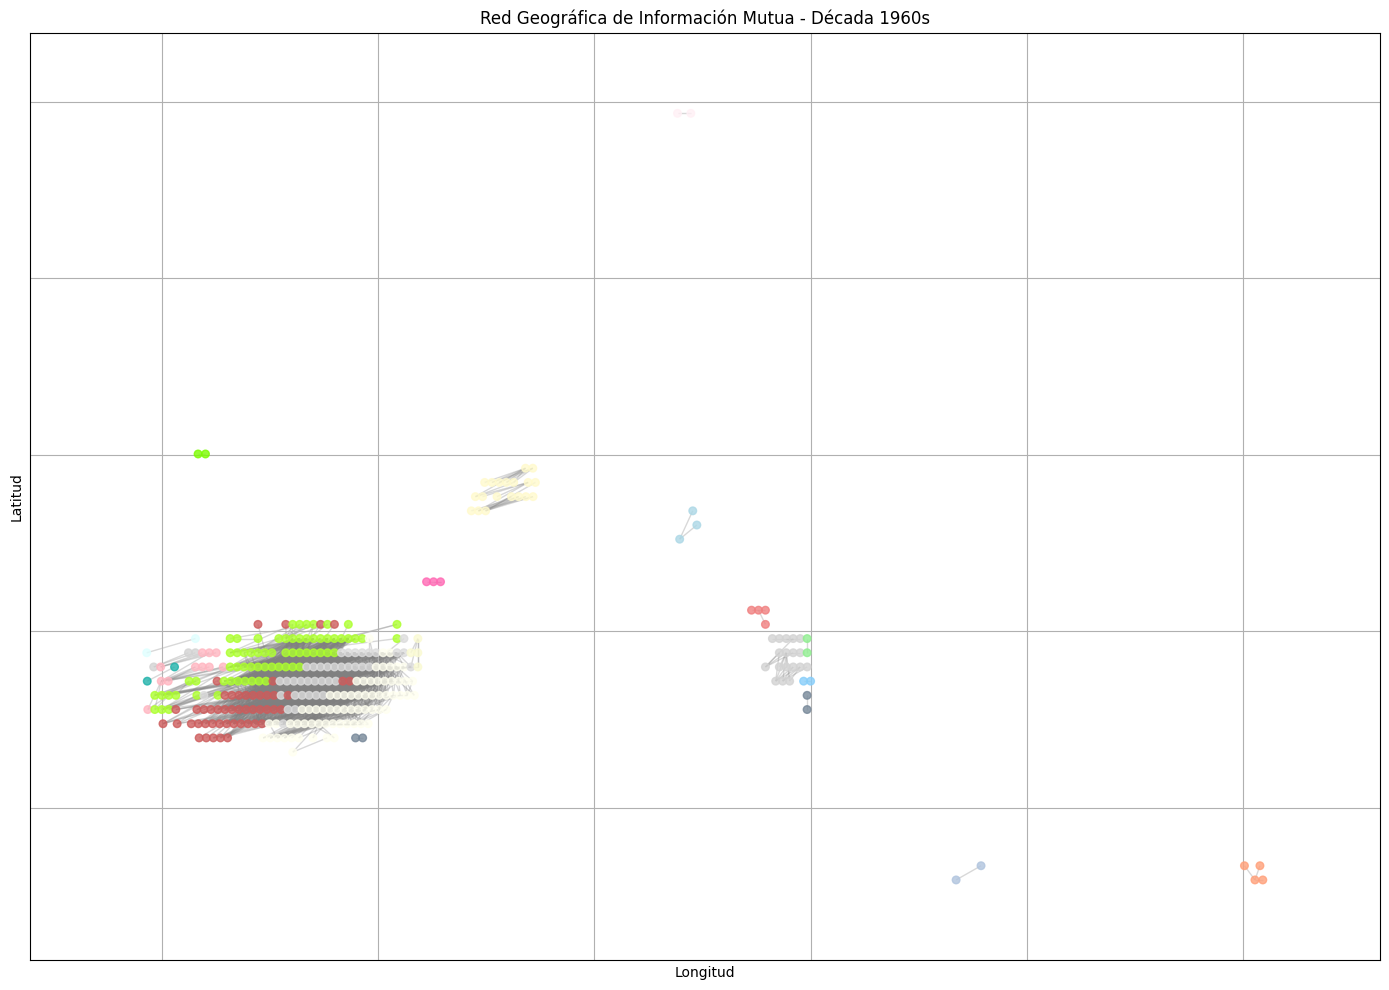

Década 1970: Modularidad = 0.5551, Número de Comunidades = 27


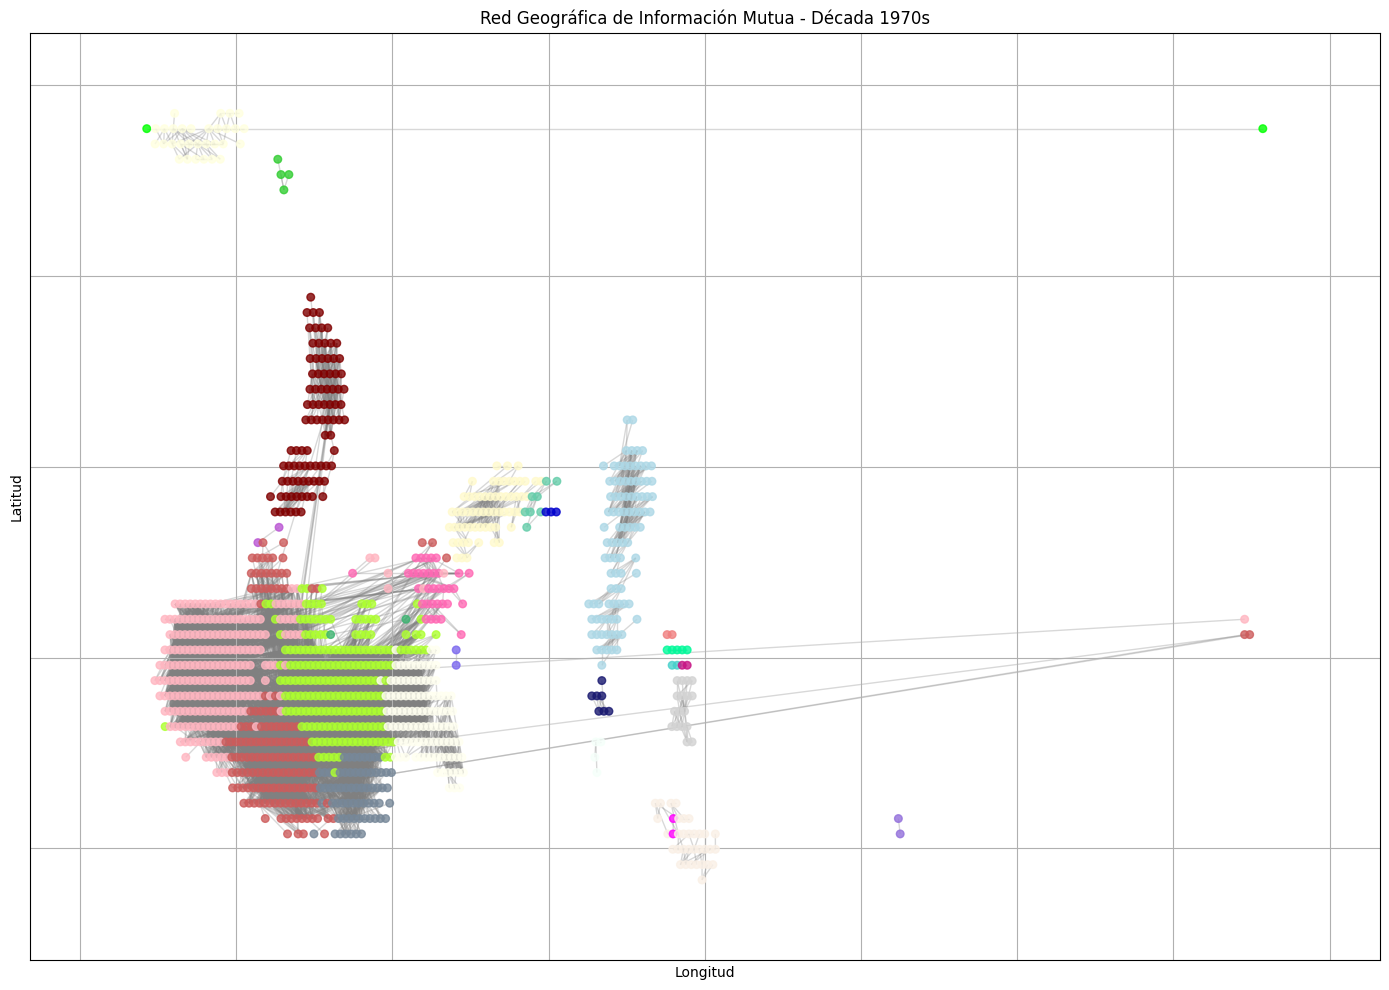

Década 1980: Modularidad = 0.5396, Número de Comunidades = 12


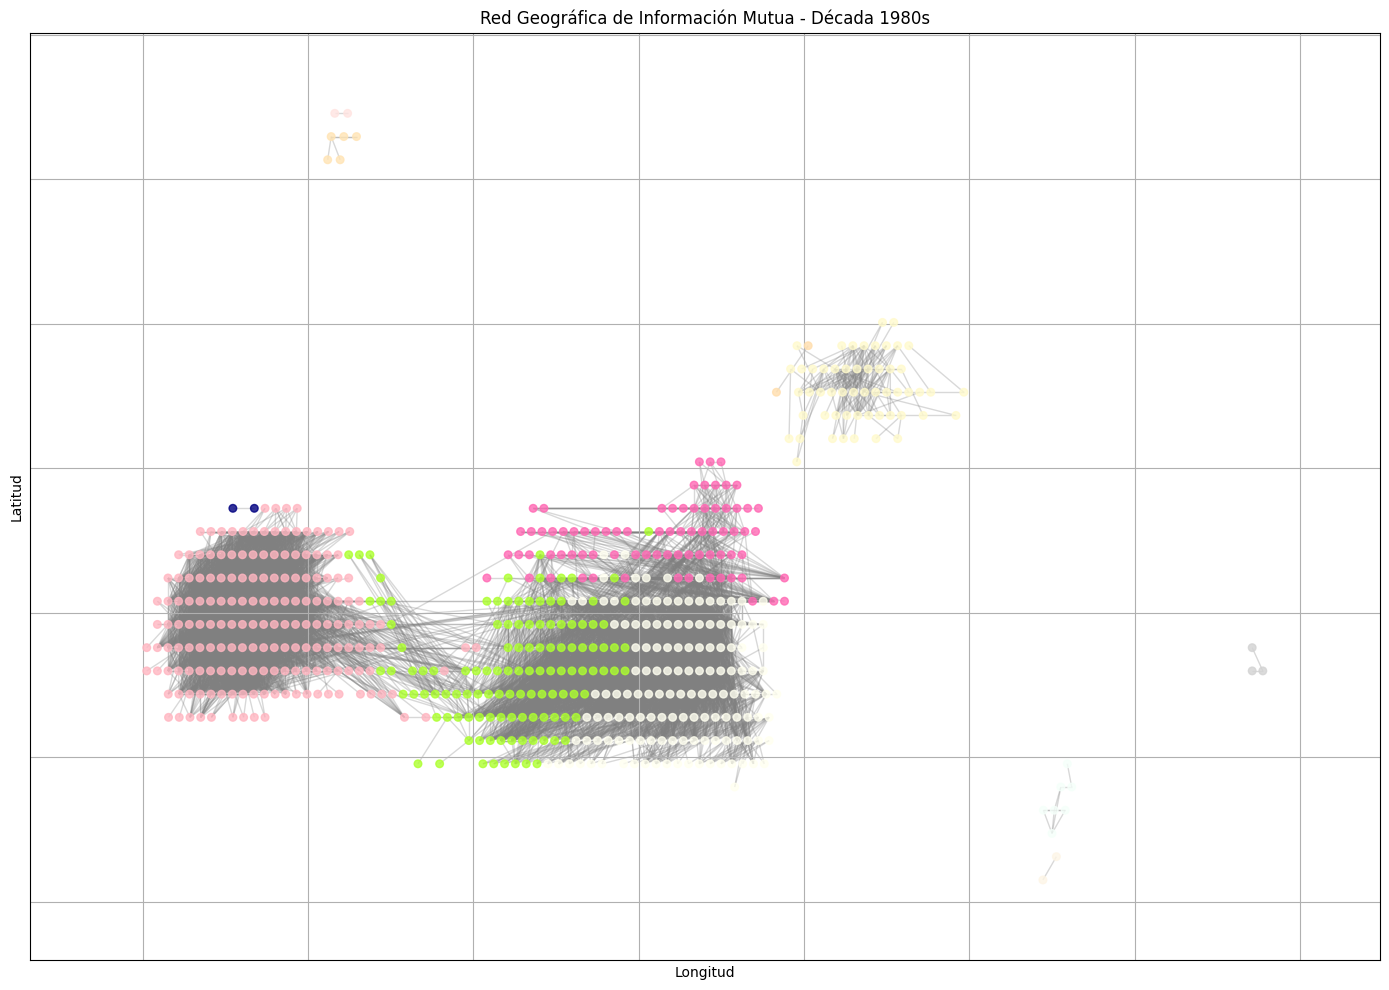

Década 1990: Modularidad = 0.3313, Número de Comunidades = 22


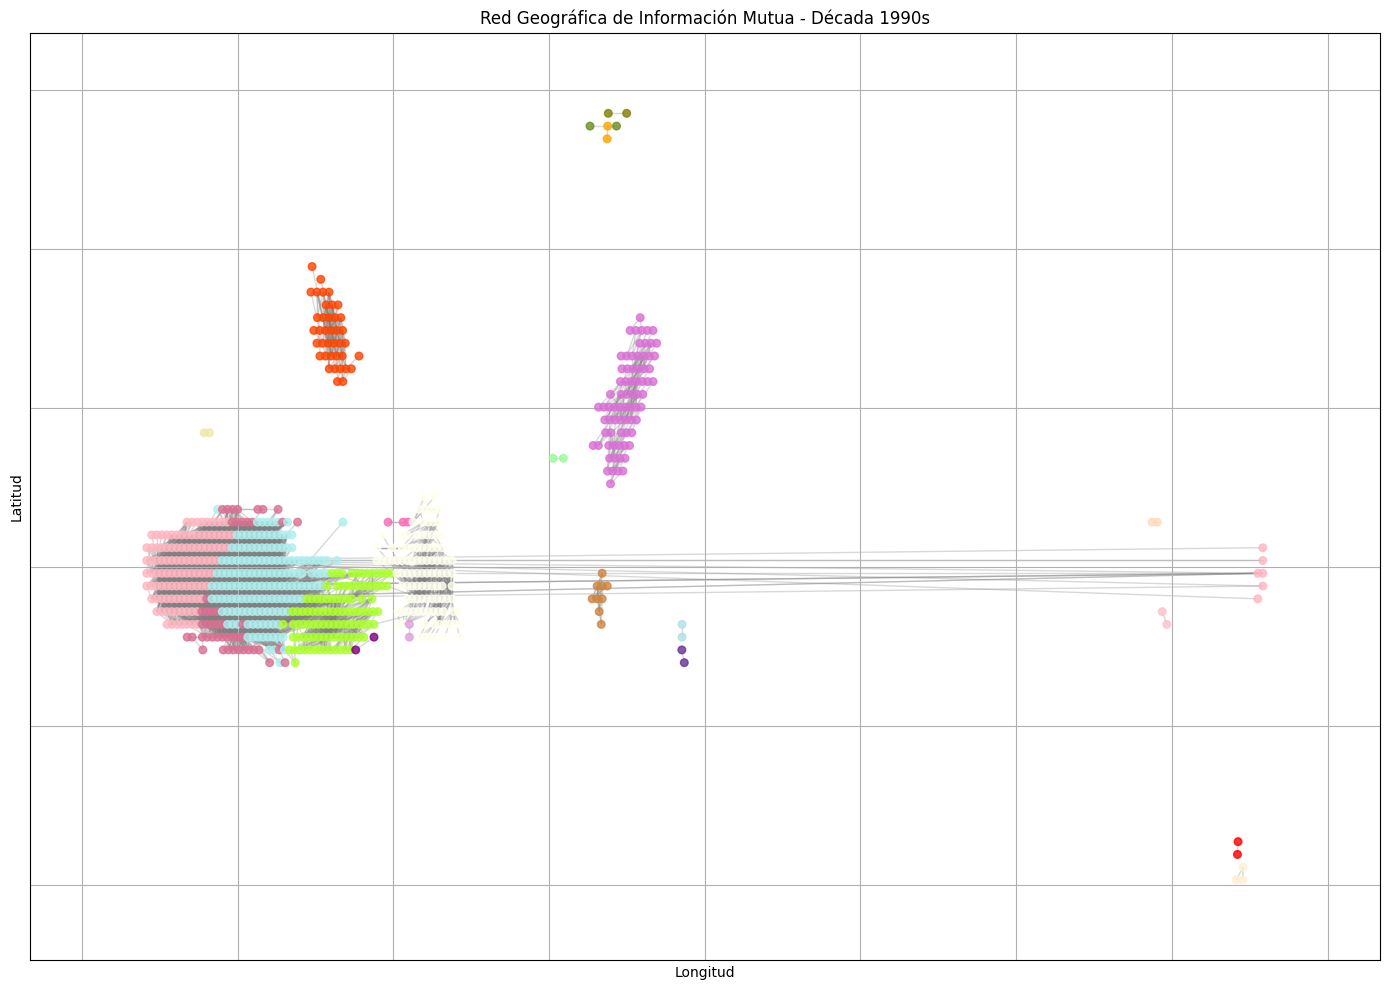

Década 2000: Modularidad = 0.1774, Número de Comunidades = 19


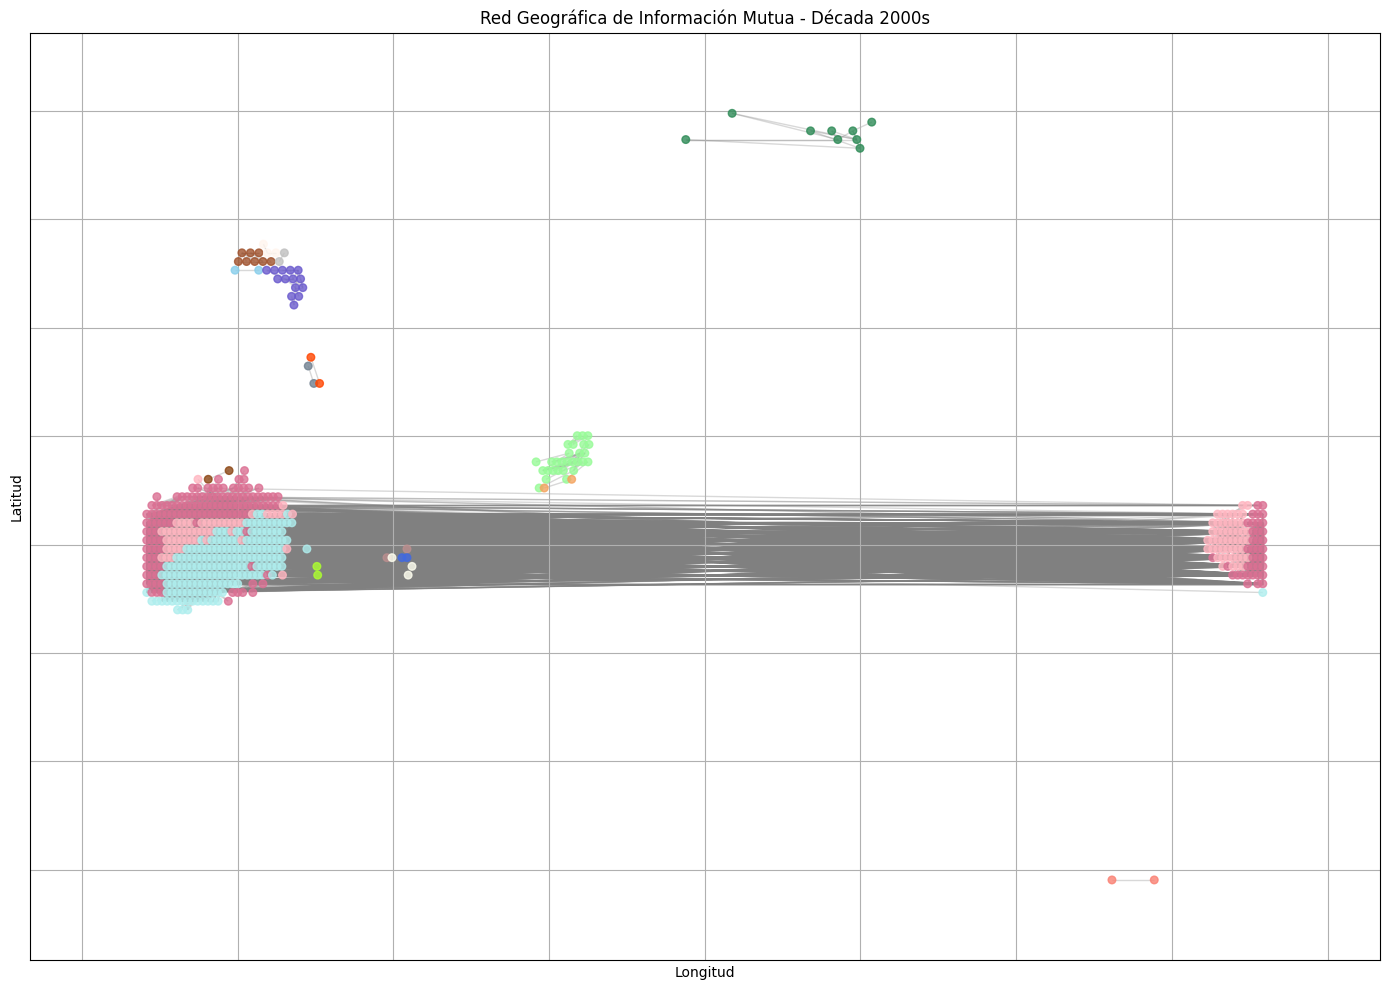

Década 2010: Modularidad = 0.6012, Número de Comunidades = 26


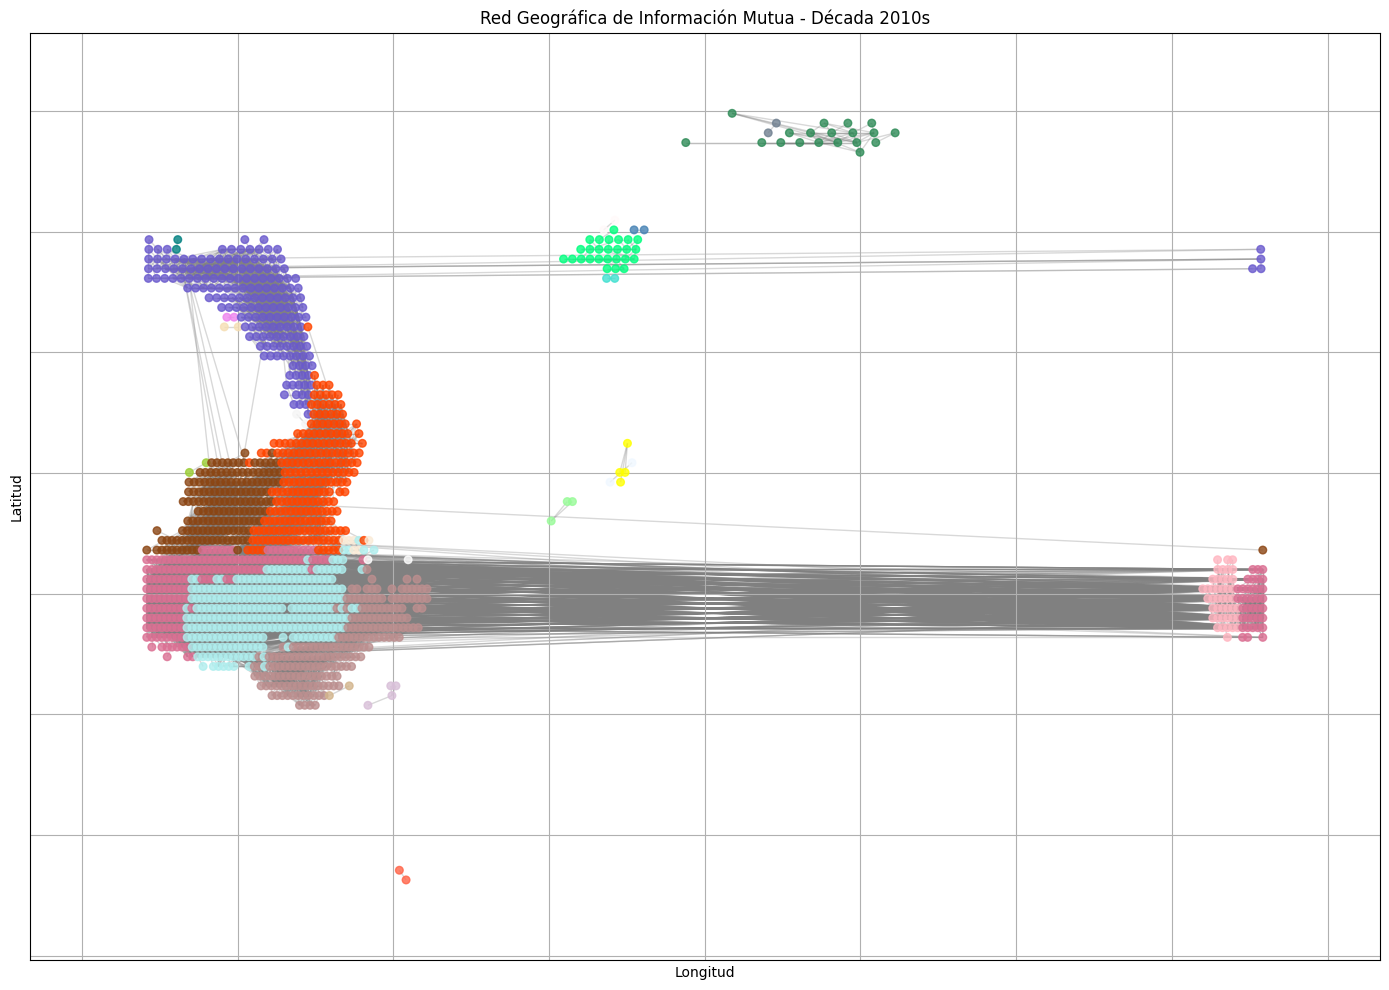

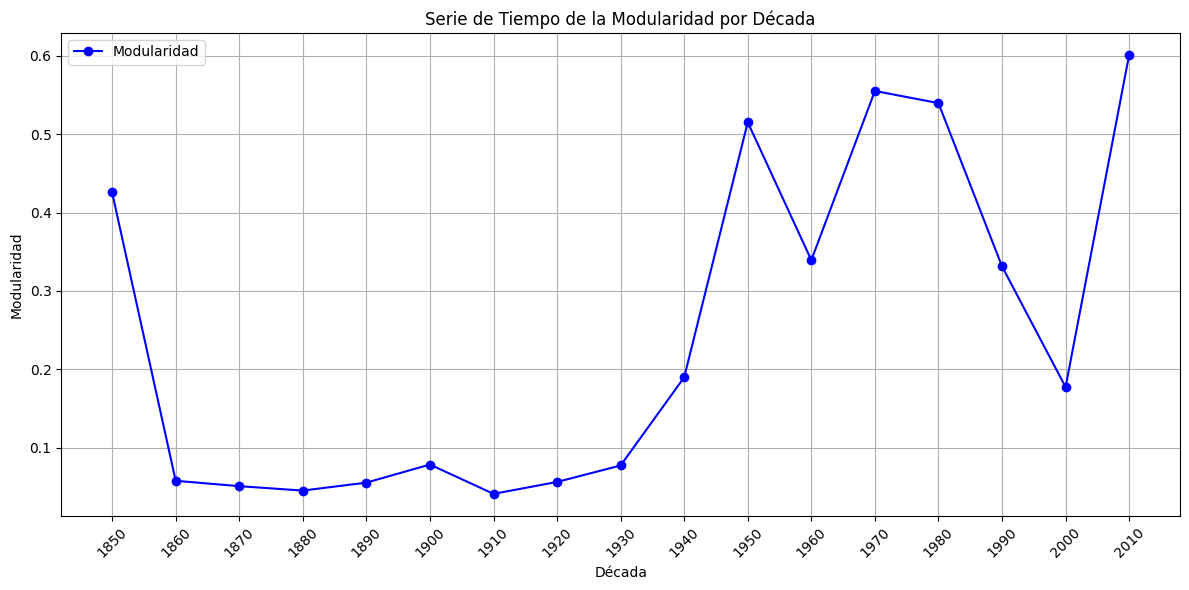

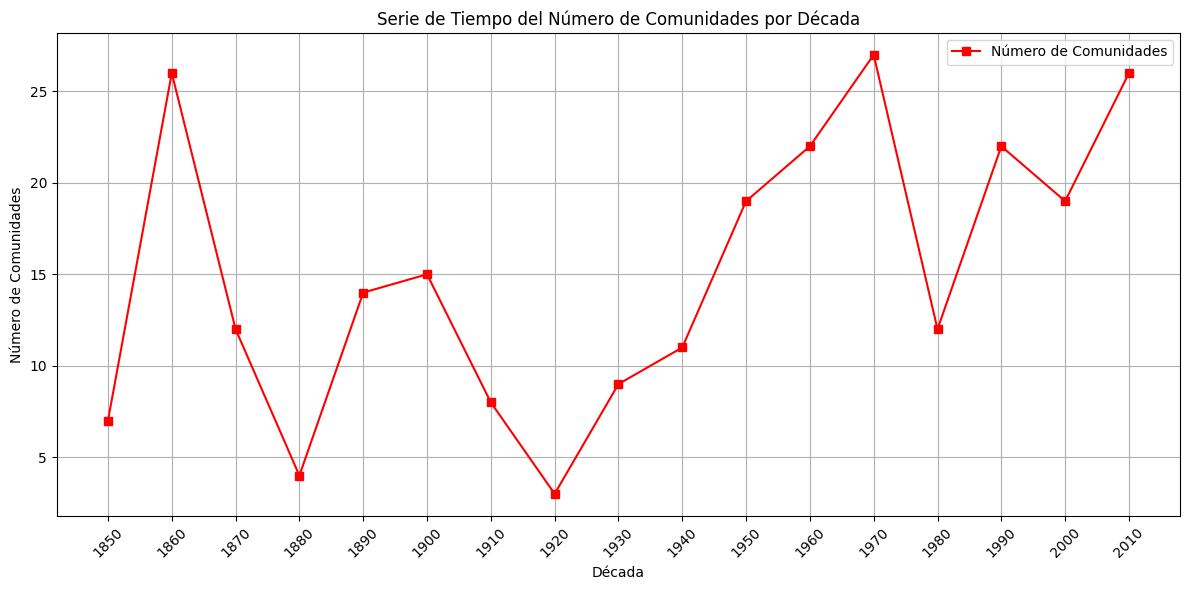

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import community  # Asegúrate de tener instalado el paquete python-louvain
import matplotlib.colors as mcolors
import pandas as pd  # Para cargar 'data' usando pandas

# Lista de décadas que quieres visualizar, empezando desde 1850
decades = [str(year) for year in range(1850, 2020, 10)]

# Directorio donde están guardadas las matrices de información mutua
data_dir = "updated_decade_mutual_info_lag1"

# Asegurarse de que el directorio existe
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"El directorio '{data_dir}' no existe.")

# Inicializar listas para almacenar la modularidad y el número de comunidades por década
modularity_per_decade = []
communities_per_decade = []
available_decades = []
partitions_per_decade = {}

# Inicializar el mapeo global de comunidades a colores
global_community_color_map = {}
color_list = list(mcolors.CSS4_COLORS.keys())
color_index = 0  # Índice para asignar colores nuevos

# Definir la función para asignar etiquetas consistentes
def relabel_communities(prev_partition, current_partition):
    """
    Relabel communities in current_partition to match labels in prev_partition
    based on maximum node overlap.
    """
    import numpy as np
    from scipy.optimize import linear_sum_assignment

    # Obtener las comunidades únicas
    prev_communities = set(prev_partition.values())
    current_communities = set(current_partition.values())

    # Crear una matriz de costos (negativa de la superposición)
    cost_matrix = np.zeros((len(prev_communities), len(current_communities)))

    prev_comm_list = list(prev_communities)
    current_comm_list = list(current_communities)

    for i, prev_comm in enumerate(prev_comm_list):
        prev_nodes = {node for node, comm in prev_partition.items() if comm == prev_comm}
        for j, curr_comm in enumerate(current_comm_list):
            curr_nodes = {node for node, comm in current_partition.items() if comm == curr_comm}
            # El costo es negativo de la intersección (queremos maximizar la superposición)
            cost_matrix[i, j] = -len(prev_nodes & curr_nodes)

    # Resolver el problema de asignación
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Crear un mapeo de comunidades actuales a las etiquetas previas
    community_mapping = {}
    for i, j in zip(row_ind, col_ind):
        if -cost_matrix[i, j] > 0:
            community_mapping[current_comm_list[j]] = prev_comm_list[i]

    # Para las comunidades sin asignación, asignar nuevas etiquetas
    new_label = max(prev_communities) + 1 if prev_communities else 0
    for curr_comm in current_comm_list:
        if curr_comm not in community_mapping:
            community_mapping[curr_comm] = new_label
            new_label += 1

    # Crear una nueva partición con etiquetas actualizadas
    new_partition = {}
    for node, comm in current_partition.items():
        new_partition[node] = community_mapping[comm]

    return new_partition

previous_partition = None

# Supongamos que ya tienes las listas de latitudes y longitudes
# Asegúrate de que 'latitudes' y 'longitudes' están definidas y tienen el mismo orden que los nodos
# latitudes = [...]
# longitudes = [...]

# Iterar sobre cada década y procesar la matriz de información mutua correspondiente
for decade in decades:
    # Ruta del archivo .npy para la década
    file_path = os.path.join(data_dir, f"updated_mutual_info_matrix_decade_{decade}_lag1.npy")
    
    # Verificar si el archivo existe
    if not os.path.isfile(file_path):
        print(f"Advertencia: El archivo para la década {decade} no se encontró en '{data_dir}'. Saltando esta década.")
        continue  # Saltar a la siguiente década
    
    # Cargar la matriz de información mutua
    corr_matrix = np.load(file_path)
    
    # Crear el grafo a partir de la matriz de información mutua
    G = nx.Graph()
    
    num_nodes = corr_matrix.shape[0]
    
    # Añadir nodos con sus atributos de latitud y longitud
    # Asegúrate de que latitudes y longitudes están definidas
    for i in range(num_nodes):
        G.add_node(i, pos=(longitudes[i], latitudes[i]))
    
    # Definir el umbral de información mutua para crear aristas
    mutual_info_threshold = 0.8  # Puedes ajustar este valor según tus necesidades
    
    # Añadir aristas basadas en el umbral de información mutua
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.isfinite(corr_matrix[i, j]) and corr_matrix[i, j] >= mutual_info_threshold:
                G.add_edge(i, j, weight=corr_matrix[i, j])
    
    # Remover nodos sin conexiones (nodos aislados)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    # Verificar si hay nodos en el grafo después de eliminar nodos aislados
    if G.number_of_nodes() == 0:
        print(f"Advertencia: No hay nodos conectados en el grafo para la década {decade}. Saltando esta década.")
        continue
    
    # Detectar comunidades usando el método de Louvain
    if G.number_of_edges() == 0:
        print(f"Advertencia: No se encontraron aristas para la década {decade}.")
        modularity_per_decade.append(np.nan)
        communities_per_decade.append(np.nan)
    else:
        partition = community.best_partition(G, weight='weight')
        
        # Si no es la primera década, reasignar etiquetas
        if previous_partition is not None:
            partition = relabel_communities(previous_partition, partition)
        else:
            # Ajustar etiquetas para que empiecen desde 0
            partition = {node: comm for node, comm in partition.items()}
        
        # Almacenar la partición actual para la siguiente iteración
        previous_partition = partition.copy()
        partitions_per_decade[decade] = partition
        
        # Calcular la modularidad
        modularity = community.modularity(partition, G, weight='weight')
        modularity_per_decade.append(modularity)
        available_decades.append(decade)
        
        # Contar el número de comunidades
        num_communities = len(set(partition.values()))
        communities_per_decade.append(num_communities)
        
        print(f"Década {decade}: Modularidad = {modularity:.4f}, Número de Comunidades = {num_communities}")
        
        # Actualizar el mapeo global de comunidades a colores
        for comm in set(partition.values()):
            if comm not in global_community_color_map:
                if color_index < len(color_list):
                    global_community_color_map[comm] = color_list[color_index]
                    color_index += 1
                else:
                    # Si nos quedamos sin colores, reutilizamos
                    global_community_color_map[comm] = color_list[color_index % len(color_list)]
                    color_index += 1
        
        # Asignar colores a los nodos usando el mapeo global
        node_colors = [global_community_color_map[partition[node]] for node in G.nodes()]
        
        # Visualizar la red geográfica con colores por comunidad
        plt.figure(figsize=(14, 10))  # Imagen más grande
        pos = nx.get_node_attributes(G, 'pos')
        nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_colors, alpha=0.8)
        nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
        plt.title(f"Red Geográfica de Información Mutua - Década {decade}s")
        plt.xlabel("Longitud")
        plt.ylabel("Latitud")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
# Verificar si se calcularon modularidades y comunidades
if not modularity_per_decade:
    raise ValueError("No se calcularon modularidades ni número de comunidades para ninguna década.")

# Plotear la serie de tiempo de la modularidad por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, modularity_per_decade, marker='o', linestyle='-', color='b', label='Modularidad')
plt.title("Serie de Tiempo de la Modularidad por Década")
plt.xlabel("Década")
plt.ylabel("Modularidad")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotear la serie de tiempo del número de comunidades por década
plt.figure(figsize=(12, 6))
plt.plot(available_decades, communities_per_decade, marker='s', linestyle='-', color='r', label='Número de Comunidades')
plt.title("Serie de Tiempo del Número de Comunidades por Década")
plt.xlabel("Década")
plt.ylabel("Número de Comunidades")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
